# VAE (Variational AutoEncoder)

This is an attempt to re-implement the paper VAE

Paper: https://arxiv.org/pdf/1312.6114v10.pdf

In [1]:
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
image_size = 112
batch_size = 128

In [3]:
def load_images(images):
    images = tf.io.read_file(images)
    images = tf.image.decode_jpeg(images, channels = 3)
    
    images = tf.cast(images, tf.float32)
    images = ((images/255)*2)-1
    
    images = tf.image.resize(images, [image_size, image_size], tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return images

In [4]:
def load_data(image_path, num_images = -1):
    image_list = glob(image_path)[:num_images]
    
    data = tf.data.Dataset.list_files(image_list)
    data = data.map(load_images)
    data = data.shuffle(num_images).batch(batch_size)#.prefetch(128)
    return data

In [5]:
path = 'E:\\Image Datasets\\Celeb A\\Dataset\\img_align_celeba\\img_align_celeba\\*.jpg'
data = load_data(path, num_images=10000)

In [6]:
class GaussianSampler(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        pass
    
    def call(self, inputs):
        mean, logvar = inputs
        epsilon = tf.random.normal(shape = (tf.shape(mean)), mean = 0.0, stddev = 1.0)
        return mean + tf.exp(0.5 * logvar) * epsilon

In [7]:
class DownConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size = (3, 3), strides = (2, 2), padding = 'same', **kwargs):
        super().__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, 
                                           padding = padding)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.2)
        
    def call(self, inputs):
        return self.leaky_relu(self.batch_norm(self.conv(inputs)))

In [8]:
class UpConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size = (3, 3), strides = (1, 1), padding = 'same', **kwargs):
        super().__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, 
                                           padding = padding)
        self.leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.2)
        self.up_sample = tf.keras.layers.UpSampling2D(size = (2, 2))
        
    def call(self, inputs):
        return self.up_sample(self.leaky_relu(self.conv(inputs)))

In [9]:
def encoder_model(latent_dim = 200):
    
    inp = tf.keras.layers.Input(shape = (image_size, image_size, 3), dtype = tf.float32, 
                                name = f'encoder_input_{latent_dim}')
    
    x = DownConvBlock(filters = 32, kernel_size = (3, 3), strides = (2, 2))(inp)
    x = DownConvBlock(filters = 32, kernel_size = (3, 3), strides = (2, 2))(x)
    x = DownConvBlock(filters = 64, kernel_size = (3, 3), strides = (2, 2))(x)
    x = DownConvBlock(filters = 64, kernel_size = (3, 3), strides = (2, 2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    mean = tf.keras.layers.Dense(units = latent_dim)(x)
    logvar = tf.keras.layers.Dense(units = latent_dim)(x)
    
    out = GaussianSampler()([mean, logvar])
    
    return tf.keras.models.Model(inp, [out, mean, logvar], name = 'Encoder')

In [10]:
def decoder_model(latent_dim = 200):
    
    inp = tf.keras.layers.Input(shape = (latent_dim), name = f'decoder_input_{latent_dim}')
    
    x = tf.keras.layers.Dense(units = 7*7*64, activation = 'tanh')(inp)
    x = tf.keras.layers.Reshape((7, 7, 64))(x)
    
    x = UpConvBlock(filters = 64, kernel_size = (3, 3), strides = (1, 1))(x)
    x = UpConvBlock(filters = 64, kernel_size = (3, 3), strides = (1, 1))(x)
    x = UpConvBlock(filters = 32, kernel_size = (3, 3), strides = (1, 1))(x)
    x = UpConvBlock(filters = 32, kernel_size = (3, 3), strides = (1, 1))(x)
    
    x = tf.keras.layers.Conv2D(filters = 3, kernel_size = (3, 3), strides = (1, 1), 
                               padding = 'same')(x)
    x = tf.keras.layers.Activation('tanh')(x)
    
    return tf.keras.models.Model(inp, x, name = 'Decoder')

In [11]:
encoder = encoder_model()
decoder = decoder_model()

In [12]:
def kl_loss(mean, logvar, kl_weight = 0.01):
    return -0.5 * tf.math.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar)) * kl_weight

def reconstruction_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.square(y_true - y_pred))

In [13]:
enc_opt = tf.keras.optimizers.RMSprop(learning_rate=1e-3)
dec_opt = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

In [14]:
@tf.function
def train_step(train_images):
    
    with tf.GradientTape(persistent = True) as tape:
        enc_out, mean, logvar = encoder(train_images, training = True)
        gen_img = decoder(enc_out, training = True)
        
        loss = kl_loss(mean, logvar) + reconstruction_loss(train_images, gen_img)
        
    enc_grads = tape.gradient(loss, encoder.trainable_variables)
    enc_opt.apply_gradients(zip(enc_grads, encoder.trainable_variables))
    
    dec_grads = tape.gradient(loss, decoder.trainable_variables)
    dec_opt.apply_gradients(zip(dec_grads, decoder.trainable_variables))
    
    return loss

In [15]:
def train(data, epochs = 1):
    for e in range(epochs):
        print(f'Epoch {e} Starts')
        for img in data:
            loss = train_step(img)
            print('.', end='')
            
        print(f'\nEpoch {e} Ends\n')

In [16]:
train(data, epochs = 50)

Epoch 0 Starts
...............................................................................
Epoch 0 Ends

Epoch 1 Starts
...............................................................................
Epoch 1 Ends

Epoch 2 Starts
...............................................................................
Epoch 2 Ends

Epoch 3 Starts
...............................................................................
Epoch 3 Ends

Epoch 4 Starts
...............................................................................
Epoch 4 Ends

Epoch 5 Starts
...............................................................................
Epoch 5 Ends

Epoch 6 Starts
...............................................................................
Epoch 6 Ends

Epoch 7 Starts
...............................................................................
Epoch 7 Ends

Epoch 8 Starts
...............................................................................
Epoch 8 Ends

Epoch 9 Starts
....

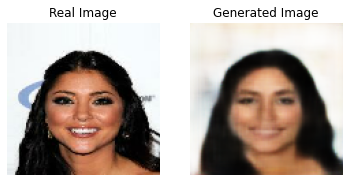

In [29]:
sample = next(iter(data))

plt.subplot(121)
plt.imshow(((sample[0]+1)*127.5).numpy().astype('uint8'))
plt.title('Real Image')
plt.axis('off')


plt.subplot(122)
plt.imshow(((decoder(encoder(sample)[0])[0]+1)*127.5).numpy().astype('uint8'))
plt.title('Generated Image')
plt.axis('off')

plt.show()